In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table, join, Column
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn import mixture, preprocessing
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial.distance as distance
from sklearn.metrics.cluster import v_measure_score, homogeneity_completeness_v_measure

In [2]:
# load data from APOGEE
ap_file = fits.open('results-unregularized-matched.fits')
# print (ap_file[1].header.keys)
ap_data = ap_file[1].data
feature_names = ['APOGEE_ID', 'GLON', 'GLAT', 'RA', 'DEC', 'VHELIO_AVG', 'LOGG', 'TEFF', 'PMRA', 'PMDEC', 
                 'AL_H', 'NA_H', 'O_H', 'MG_H','C_H', 'N_H', 'V_H', 'TI_H', 'CA_H','FE_H', 'K_H', 'MN_H', 'NI_H', 'SI_H', 'S_H', 
                 'SNR']
feature_names = np.array(feature_names)
element_names = ['AL_H', 'NA_H', 'O_H', 'MG_H','C_H', 'N_H', 'V_H', 'TI_H', 'CA_H','FE_H', 'K_H', 'MN_H', 'NI_H', 'SI_H', 'S_H']
element_names = np.array(element_names)
elements = np.array([name.replace('_H', '').title() for name in element_names])
print elements
# append data into columns
ap_cols = []
for name in feature_names:
    ap_cols.append(ap_data.field(name))
ap_cols = np.array(ap_cols)
ap_cols = ap_cols.T
# create a table with the data columns
dtype = ['float' for n in range(len(feature_names))]
dtype[0] = 'string'
ap_table = Table(data=ap_cols, names=feature_names, dtype=dtype)

['Al' 'Na' 'O' 'Mg' 'C' 'N' 'V' 'Ti' 'Ca' 'Fe' 'K' 'Mn' 'Ni' 'Si' 'S']


In [3]:
VSCATTER = ap_data.field('VSCATTER')
VERR = ap_data.field('VERR')
VERR_MED = ap_data.field('VERR_MED')

print stats.describe(VSCATTER)
print stats.describe(VERR[np.where(VERR < 999999.0)[0]])
print stats.describe(VERR_MED[np.where(VERR_MED < 999999.0)[0]])

DescribeResult(nobs=150677, minmax=(0.0, 728.46301), mean=1.9518722, variance=282.13364, skewness=25.045862197875977, kurtosis=744.0229804805617)
DescribeResult(nobs=150676, minmax=(0.00049263501, 100.647), mean=0.11195551, variance=0.75150317, skewness=51.107852935791016, kurtosis=4141.397306736289)
DescribeResult(nobs=150676, minmax=(0.00081579201, 231.218), mean=0.20478323, variance=2.7382169, skewness=56.199153900146484, kurtosis=5119.267948405164)


In [4]:
# add membership and number labels for clusters
known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
member_IDs = known_clusters[0]
member_names = known_clusters[1]
labels = np.zeros(len(member_IDs))-1
cluster_names = list(set(member_names))
print cluster_names
k = 0
for name in cluster_names:
    index = np.where(member_names == name)[0]
    labels[index] = k
    k += 1
names = ['APOGEE_ID', 'cluster_name', 'label']
dtype=['string', 'string', 'int']
member_table = Table(data=[member_IDs, member_names, labels], names=names, dtype=dtype)
ap_table = join(ap_table, member_table, keys='APOGEE_ID', join_type='left')

['N7789', 'M71', 'N6819', 'N6791', 'M107', 'M53', 'N2158', 'M35', 'M92', 'M67', 'N4147', 'M5', 'M13', 'N5466', 'M3', 'M2', 'M15', 'Pleiades', 'N188', 'N2420']


In [5]:
# fill missing values
ap_table['cluster_name'].fill_value = 'background'
ap_table['label'].fill_value = -1
for element in element_names:
    ap_table[element].mask = np.isnan(ap_table[element])
    ap_table[element].fill_value = -9999.
ap_table = ap_table.filled()

In [6]:
# get stars with 15 elements
ap_stars_15 = np.arange(len(ap_table))
for element in element_names:
    ap_stars_15 = np.intersect1d(ap_stars_15, np.where(ap_table[element] > -999.)[0])
ap_table_15 = ap_table[ap_stars_15]
print "There are %i stars with 15 elements."%len(ap_table_15)
halo_index = np.where((ap_table_15['GLAT'] < -10.) | (ap_table_15['GLAT'] > 10.))[0]
ap_table_15 = ap_table_15[halo_index]
print "In the halo, there are %i stars with 15 elements."%len(ap_table_15)

There are 150615 stars with 15 elements.
In the halo, there are 70538 stars with 15 elements.


In [172]:
# get globular cluster members with 15 elements
globular_names = np.array(['M107', 'M53', 'M92', 'M67', 'M5', 'M13', 'M3', 'M2', 'M15', 'N5466'])
globular_members = np.array([], dtype='int')
globular_labels = np.array([], dtype='int')
k = 0
save_list = []
for name in globular_names:
    cluster_members = np.where(ap_table_15['cluster_name'] == name)[0]
    if len(cluster_members) <= 0:
        print "%s has %i members"%(name, 0)
    else:
        cluster_labels = ap_table_15['label'][cluster_members][0]
        globular_members = np.append(globular_members, cluster_members)
        globular_labels = np.append(globular_labels, cluster_labels)
        save_list.append(k)
        print "%s has %i members"%(name, len(cluster_members))
    k += 1
globular_names = np.array([globular_names[i] for i in save_list])
print globular_names
print globular_labels

M107 has 18 members
M53 has 16 members
M92 has 48 members
M67 has 24 members
M5 has 103 members
M13 has 71 members
M3 has 73 members
M2 has 19 members
M15 has 11 members
N5466 has 8 members
['M107' 'M53' 'M92' 'M67' 'M5' 'M13' 'M3' 'M2' 'M15' 'N5466']
[ 4  5  8  9 11 12 14 15 16 13]


In [8]:
Fe_index = np.where(element_names == 'FE_H')[0][0]
chem = [ap_table_15[element]-ap_table_15['FE_H'] for element in element_names]
chem[Fe_index] = ap_table_15['FE_H']
chem.append(ap_table_15['VHELIO_AVG'])
use_chem_RV = np.array(chem[6:]).T
print use_chem_RV.shape

(70538, 10)


In [9]:
def jaccard(a,b):
    A = np.array(a, dtype='int')
    B = np.array(b, dtype='int')
    A = A[np.where(A > -1)[0]]
    B = B[np.where(B > -1)[0]]
    union = np.union1d(A,B)
    intersection = np.intersect1d(A,B)
    return 1.0 - len(intersection)*1.0 / len(union)

In [10]:
def get_friends(data, num_element, n_chem, n_rv):
    data = np.array(data)
    index_chem = np.arange(0, num_element, 1)
    nbrs_chem = NearestNeighbors(n_neighbors=n_chem, algorithm='ball_tree', metric='manhattan').fit(data[:,index_chem])
    distances_chem, indices_chem = nbrs_chem.kneighbors(data[:,index_chem])
    index_rv = np.arange(num_element, len(data[0]), 1)
    rv_data = np.copy(data[:,index_rv])
#     indices_rv = np.array([np.where(np.abs(rv - rv_data) < 1)[0] for rv in rv_data])
    if len(rv_data[0]) < 2:
        rv_data = rv_data.reshape(-1, 1)
    nbrs_rv = NearestNeighbors(n_neighbors=n_rv, algorithm='ball_tree').fit(rv_data)
    distances_rv, indices_rv = nbrs_rv.kneighbors(rv_data)
    indices = []
    for n in range(len(indices_chem)):
        indices.append(np.intersect1d(indices_chem[n], indices_rv[n]))
    indices = np.array(indices)
    return indices

In [27]:
%time indices = get_friends(use_chem_RV, 9, 500, 300)

CPU times: user 3min 17s, sys: 781 ms, total: 3min 18s
Wall time: 3min 18s


In [28]:
lengths = np.array([len(indices[n]) for n in range(len(indices))])
H, edges = np.histogram(lengths)
for n in range(len(H)):
    print H[n], edges[n+1]

67028 14.6
2068 28.2
646 41.8
492 55.4
143 69.0
46 82.6
49 96.2
23 109.8
30 123.4
13 137.0


In [29]:
for name in globular_names:
    c_members = np.where(ap_table_15['cluster_name'] == name)[0]
    print name
    print lengths[c_members]

M107
[ 3  6  4  7  2  3  5 17  2  3  1  2  3  3  5  7  7  2]
M13
[ 85  65 133 103  80  51 107  91  66 108  80 108 103  10  77  65  70  43
  39  75  70  74 122  62  90  64  77  84  76  79  93  89  93  95  72 115
  60 129 105 120  71  85 120  90  82 115  94 125 107 115  98  66 110  91
 119 137 134  81  65 119 132  56  65  91 110  59 117  44  54  43 118]
M15
[42 36 30 18 14 42 40 10 27 15 13]
M2
[1 2 2 1 1 2 1 1 1 2 2 1 2 1 1 3 1 2 1]
M3
[50 56 11  9 53 42 28 46 48 62 39 21  5 62 40  4 51 48 54 51 32 39 57 32 57
 42  1  8 52 32  9 31 41 60 52 32 52 59 39 50 34 29 53 32 50 50 45 49 26  5
 39 64 62 40 40 51 48 53 41 28 26 54 57 35 54 45 27 26  5 40 53 44 13]
M5
[21  8 12  9 13 27 17 10  2 12  5  8 16 14  7 11  7 12  8 13  6 19 10 11 11
 11  6  7 12  9 11 17  3  8  8  2  4  2  9 14  7  9  9 19  2  5 10  8  9  4
 16 10  7  6 10 10  5  5 11  2 17  3  6 14  7  8 14  5 10  2  6 12 11  9 19
  7  7 12 15  9 14 10 11 10  6  8 13 12 11 18 15  6 13 20 13 11 20 18  8 10
 11 18 22]
M53
[ 3  3  5  4  3 

In [33]:
non_noise = np.where(lengths > 1)[0]
print len(non_noise)
# show remaining globular clusters
for name in globular_names:
    members_gc = np.where(ap_table_15['cluster_name'] == name)[0]
    remain = np.intersect1d(members_gc, non_noise)
    if len(remain) <= 0:
        print "%s has %i members"%(name, 0)
    else:
        print "%s has %i members"%(name, len(remain)), len(remain)*1.0/len(members_gc)

64856
M107 has 17 members 0.944444444444
M13 has 71 members 1.0
M15 has 11 members 1.0
M2 has 8 members 0.421052631579
M3 has 72 members 0.986301369863
M5 has 103 members 1.0
M53 has 16 members 1.0
M92 has 48 members 1.0
N5466 has 8 members 1.0


In [31]:
def iterator_dist(indices):
    for n in range(len(indices)):
        for m in range(n+1, len(indices)):
            dist = jaccard(indices[n], indices[m])
            if dist < 1:
                yield (n, m, dist)

In [34]:
%%time

from scipy.sparse import lil_matrix

S = lil_matrix((len(non_noise), len(non_noise)))
for (n, m, dist) in iterator_dist(indices[non_noise]):
    S[n,m] = dist
    S[m,n] = dist

CPU times: user 1d 2h 11min 59s, sys: 6.87 s, total: 1d 2h 12min 6s
Wall time: 1d 2h 12min 11s


In [69]:
for name in globular_names:
    members = np.where(ap_table_15["cluster_name"][non_noise] == name)[0]
    print name
    d = S[members][:,members].toarray()
    for row in d:
        d_nz = np.sort(row[row != 0])
        if len(d_nz) > 4:
            print d_nz[:3]

M107
M13
[ 0.1978022   0.27659574  0.29347826]
[ 0.32051282  0.33333333  0.38823529]
[ 0.10714286  0.11678832  0.14583333]
[ 0.14159292  0.18103448  0.29565217]
[ 0.17647059  0.18085106  0.24742268]
[ 0.30357143  0.328125    0.33333333]
[ 0.14159292  0.1779661   0.20338983]
[ 0.15306122  0.18085106  0.28448276]
[ 0.16176471  0.18055556  0.21052632]
[ 0.2265625   0.26315789  0.28205128]
[ 0.36521739  0.38053097  0.38679245]
[ 0.1779661   0.18103448  0.296     ]
[ 0.21311475  0.3359375   0.34482759]
[ 0.09090909  0.11392405  0.12048193]
[ 0.26829268  0.28395062  0.30666667]
[ 0.40206186  0.41304348  0.43023256]
[ 0.48717949  0.5         0.5       ]
[ 0.29166667  0.30909091  0.36666667]
[ 0.17647059  0.28125     0.28865979]
[ 0.09090909  0.10666667  0.16049383]
[ 0.16        0.26666667  0.27835052]
[ 0.23239437  0.29411765  0.31818182]
[ 0.22535211  0.3         0.30666667]
[ 0.17346939  0.1875      0.25714286]
[ 0.16        0.22535211  0.34615385]
[ 0.26829268  0.28723404  0.29032258]
[ 0

In [116]:
%%time 

db = DBSCAN(eps=0.35, min_samples=8, metric='precomputed', n_jobs=-1).fit(S, lengths[non_noise])
labels = db.labels_
n_clumps = np.amax(labels)
true_labels = ap_table_15["label"][non_noise]
print n_clumps
print len(np.where(labels != -1)[0]), len(labels), len(np.where(labels != -1)[0])*1.0/len(labels)

24
583 64856 0.00898914518318
CPU times: user 544 ms, sys: 6 ms, total: 550 ms
Wall time: 545 ms


In [175]:
# get recovered members
recovered = np.where([])
for n in range(n_clumps):
    group = np.where(labels == n)[0]
    group_labels = true_labels[group]
    members_in_group = np.where(group_labels != -1)[0]
    numbers = list(set(group_labels[members_in_group]))
    for num in numbers:
        len_cluster = len(np.where(group_labels[members_in_group] == num)[0])
        len_clusters = len(members_in_group)
        if (len_cluster == len_clusters):
            recovered = np.append(recovered, non_noise[group[np.where(group_labels == num)[0]]])
recovered = np.intersect1d(recovered, globular_members)
print ap_table_15['cluster_name'][recovered]

cluster_name
------------
         M53
         M53
         M53
         M53
          M3
          M3
          M3
          M3
          M3
          M3
         ...
         M92
         M92
         M92
         M92
         M92
         M92
         M92
         M92
         M15
         M15
         M15
Length = 146 rows


In [176]:
for name in globular_names:
    members = np.where(ap_table_15["cluster_name"] == name)[0]
    rec_member = np.intersect1d(members, recovered)
    print name, len(rec_member)*1.0/len(members), len(members)

M107 0.0 18
M53 0.25 16
M92 0.833333333333 48
M67 0.0 24
M5 0.0 103
M13 0.943661971831 71
M3 0.356164383562 73
M2 0.0 19
M15 0.272727272727 11
N5466 0.75 8


In [84]:
for name in globular_names:
    members = np.where(ap_table_15["cluster_name"] == name)[0]
    print name, np.std(ap_table_15['VHELIO_AVG'][members])
#     plt.hist(ap_table_15['VHELIO_AVG'][members])
#     plt.show()

M107 18.0105779885
M13 5.33416848092
M15 27.1165962824
M2 5.64992400868
M3 50.3984989142
M5 4.93206995286
M53 3.20959508135
M92 3.88752459629
N5466 11.4456093788


In [85]:
import cPickle as pickle

pickle.dump(labels, open("ISNN_500_300_5_8_labels.p", "wb"))
pickle.dump(non_noise, open("ISNN_500_300_5_8_stars.p", "wb"))

In [87]:
pickle.dump(S, open("ISNN_500_300_5_8_S.p", "wb"))

In [40]:
# show remaining globular clusters
for name in globular_names:
    members_gc = np.where(ap_table_15['cluster_name'] == name)[0]
    remain = np.intersect1d(members_gc, non_noise[np.where(labels != -1)[0]])
    if len(remain) <= 0:
        print "%s has %i members"%(name, 0)
    else:
        print "%s has %i members"%(name, len(remain)), len(remain)*1.0/len(members_gc)

M107 has 0 members
M13 has 63 members 0.887323943662
M15 has 8 members 0.727272727273
M2 has 0 members
M3 has 35 members 0.479452054795
M5 has 14 members 0.135922330097
M53 has 4 members 0.25
M92 has 46 members 0.958333333333
N5466 has 6 members 0.75


In [88]:
NA = ap_table_15['NA_H']-ap_table_15['FE_H']
O = ap_table_15['O_H']-ap_table_15['FE_H']
MG = ap_table_15['MG_H']-ap_table_15['FE_H']
AL = ap_table_15['AL_H']-ap_table_15['FE_H']
SI = ap_table_15["SI_H"] - ap_table_15["FE_H"]
C = ap_table_15["C_H"] - ap_table_15["FE_H"]
N = ap_table_15["N_H"] - ap_table_15["FE_H"]
CA = ap_table_15["CA_H"] - ap_table_15["FE_H"]
RV = ap_table_15['VHELIO_AVG']
GLON = ap_table_15['GLON']
GLAT = ap_table_15['GLAT']
LOGG = ap_table_15['LOGG']
TEFF = ap_table_15['TEFF']
RA = ap_table_15['RA']
DEC = ap_table_15['DEC']

In [177]:
num_g_c = len(list(set(globular_labels)))
colors = np.linspace(0, 1, num_g_c)
cm = plt.get_cmap('rainbow')
print globular_names

['M107' 'M53' 'M92' 'M67' 'M5' 'M13' 'M3' 'M2' 'M15' 'N5466']


In [178]:
print max(labels)
plot_labels = []
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    members_in_group = np.intersect1d(globular_members, group)
    if len(members_in_group) > 5:
        plot_labels.append(n)
print plot_labels

24
[9, 10, 12, 13, 15]


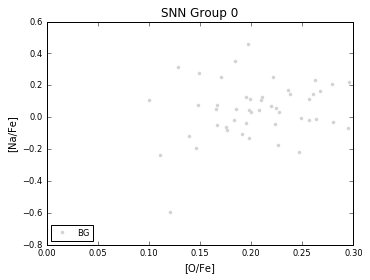

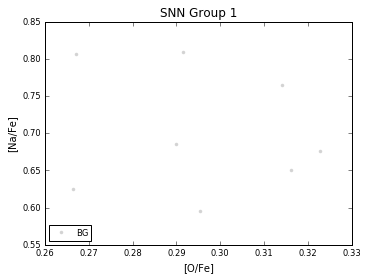

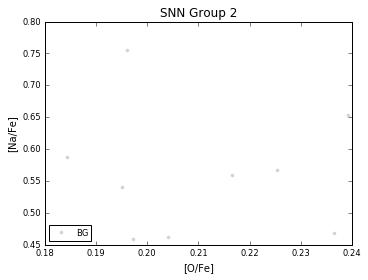

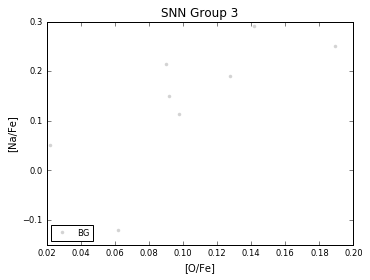

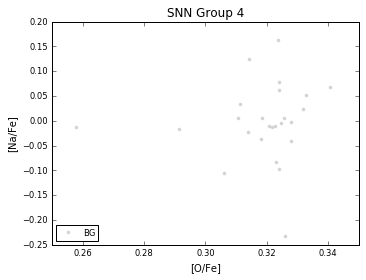

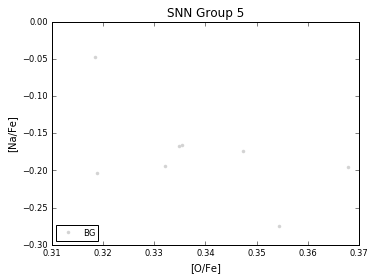

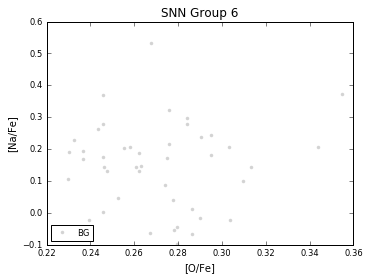

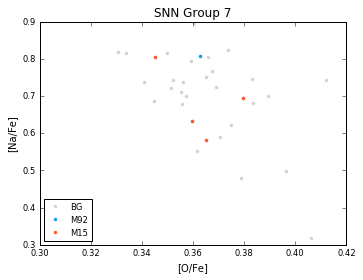

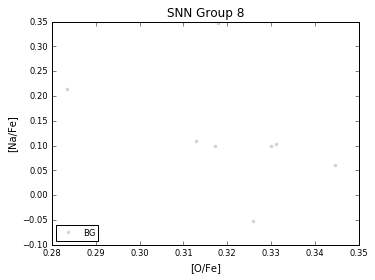

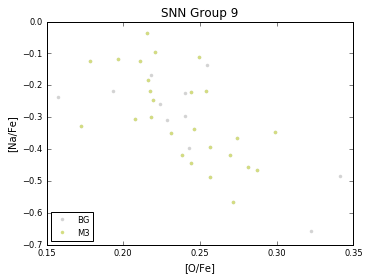

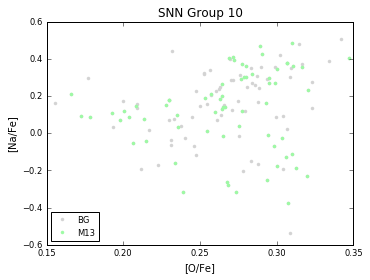

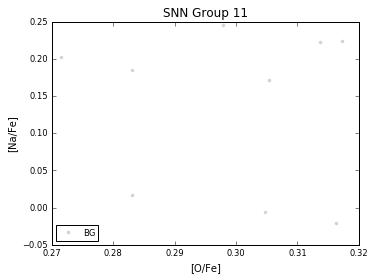

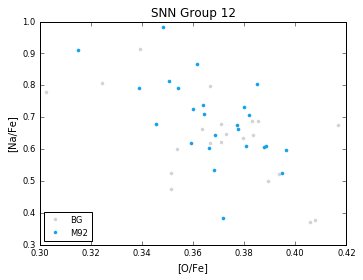

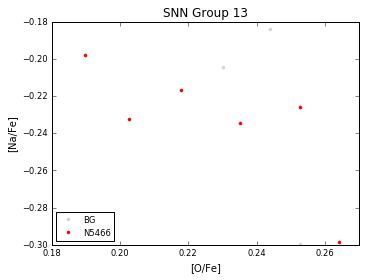

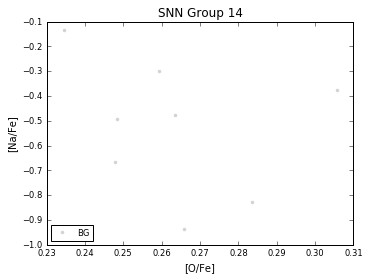

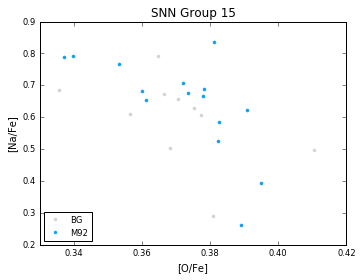

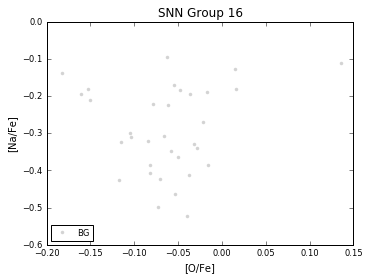

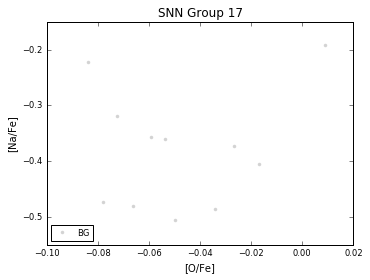

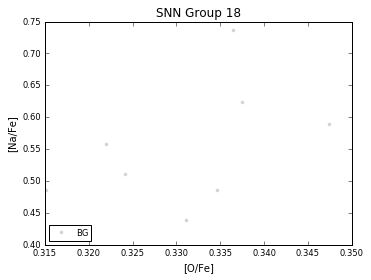

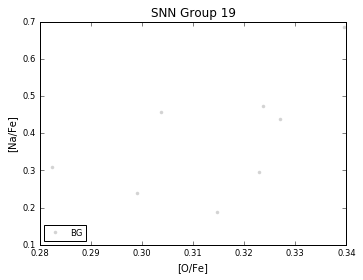

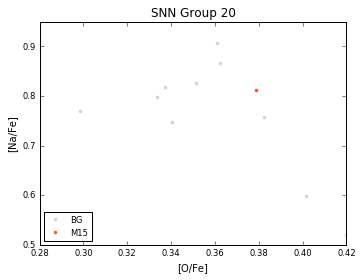

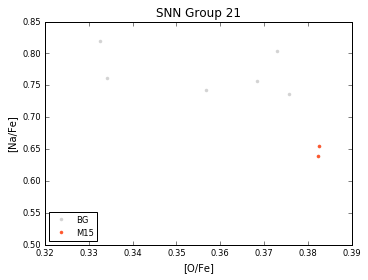

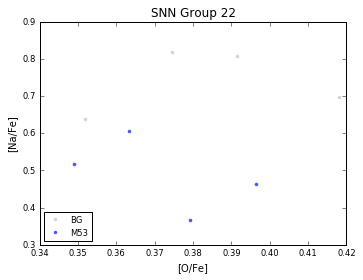

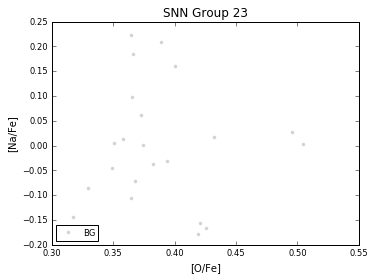

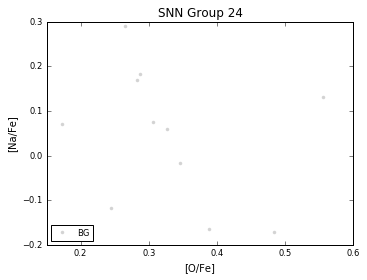

In [193]:
xlab = "[O/Fe]"
ylab = "[Na/Fe]"
X = O
Y = NA
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_15["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=3, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
    plt.savefig("Cannon/SNN/SNN_%i_O_NA.png"%n, dpi=150)
    plt.show()

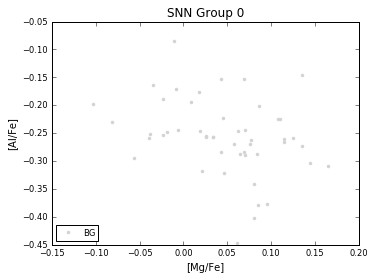

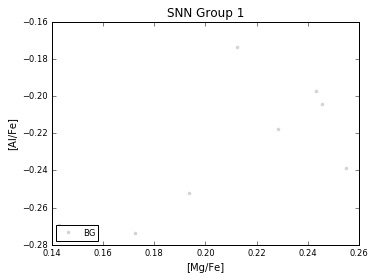

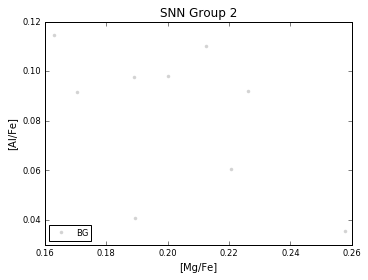

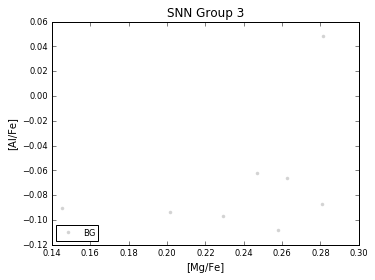

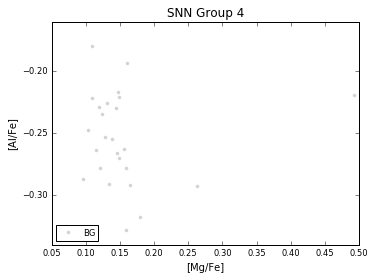

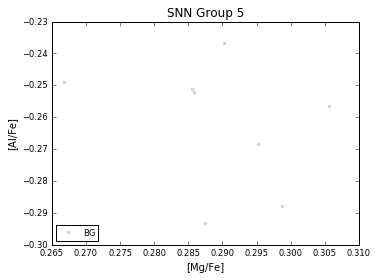

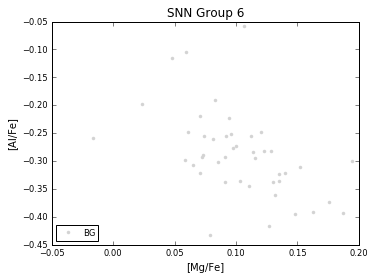

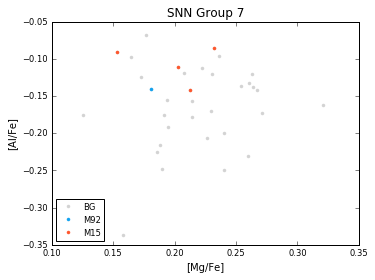

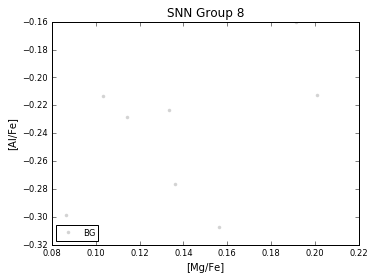

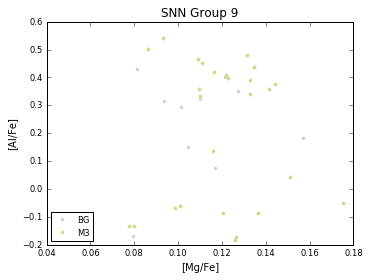

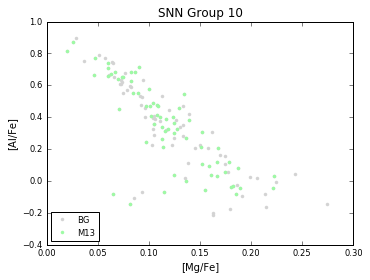

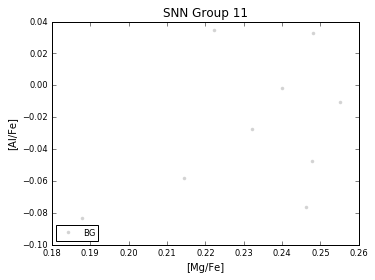

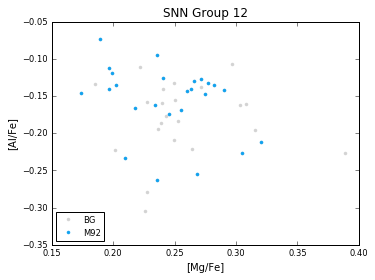

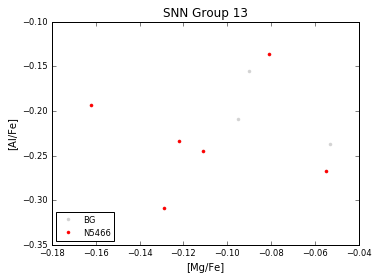

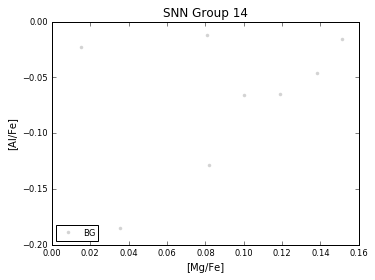

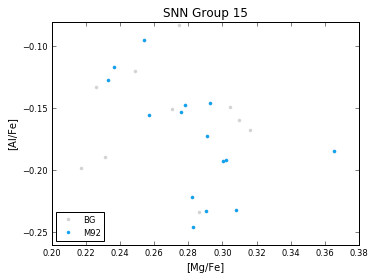

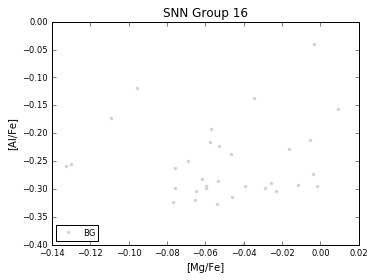

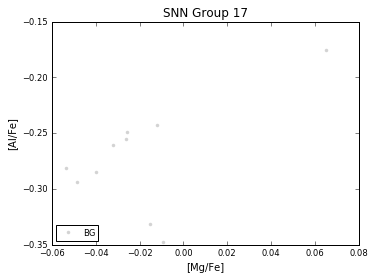

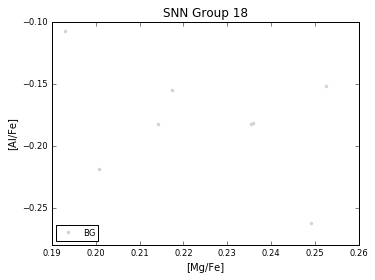

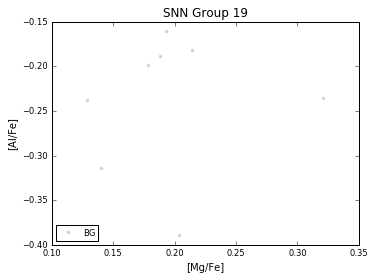

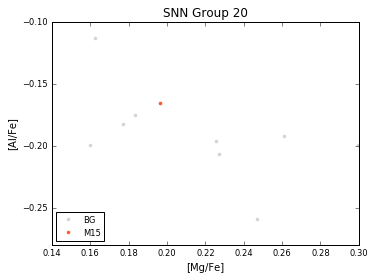

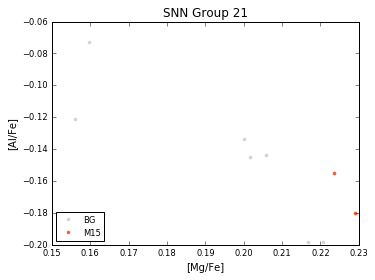

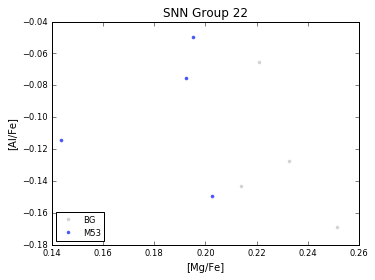

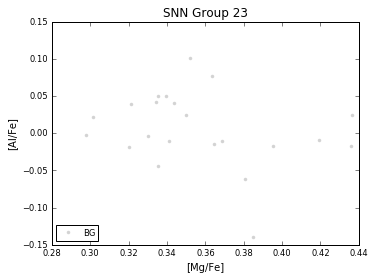

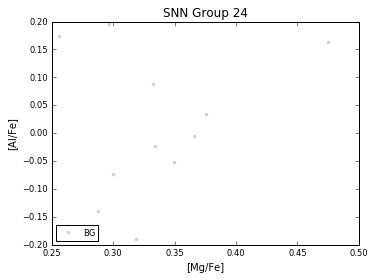

In [192]:
xlab = "[Mg/Fe]"
ylab = "[Al/Fe]"
X = MG
Y = AL
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_15["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=3, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
    plt.savefig("Cannon/SNN/SNN_%i_MG_AL.png"%n, dpi=150)
    plt.show()

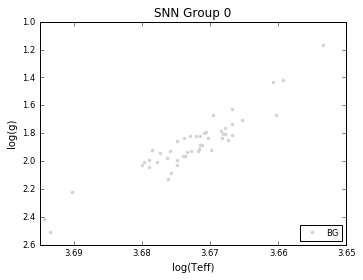

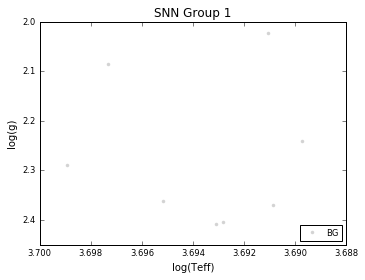

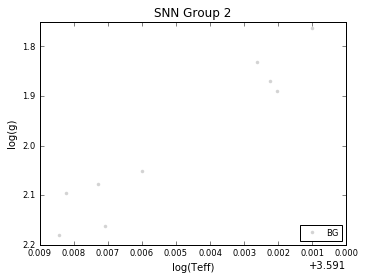

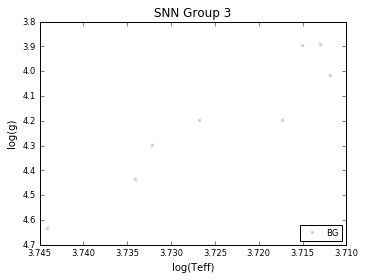

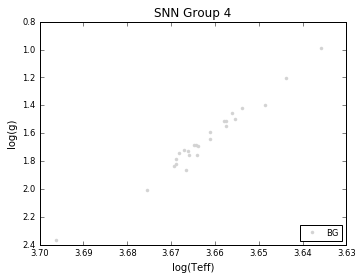

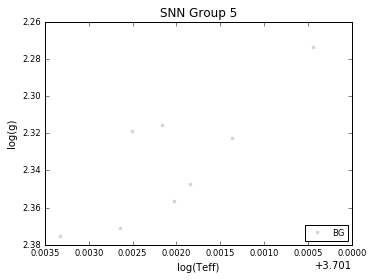

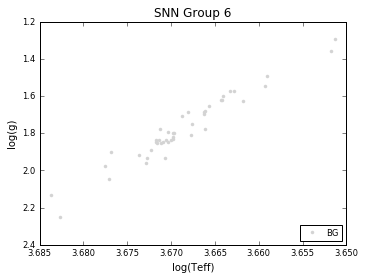

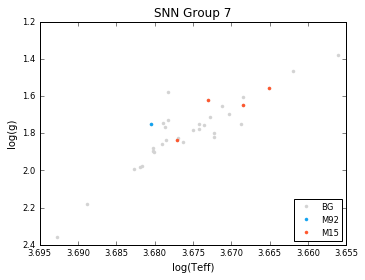

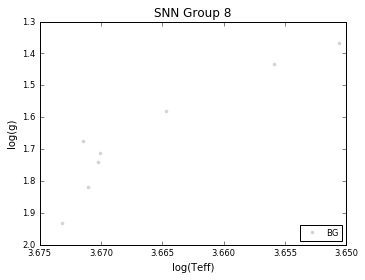

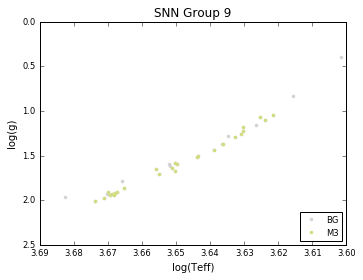

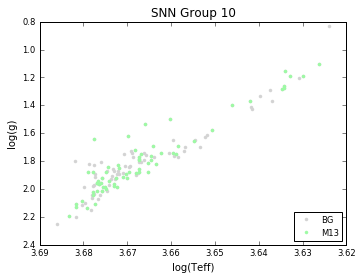

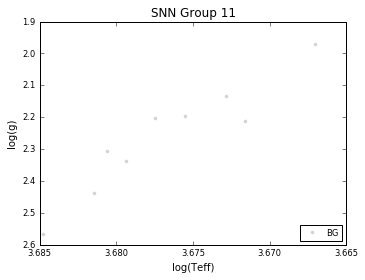

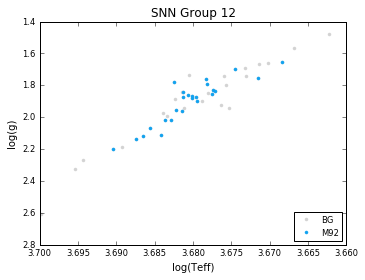

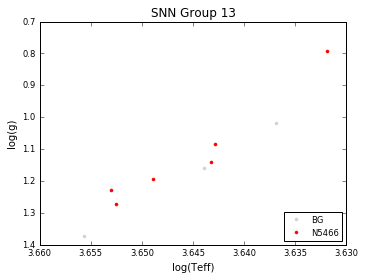

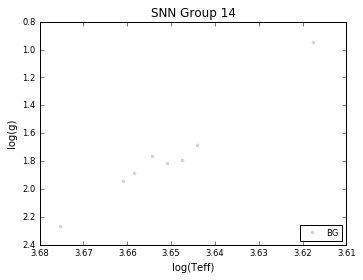

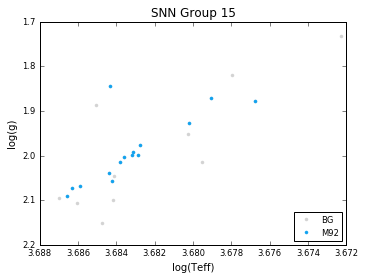

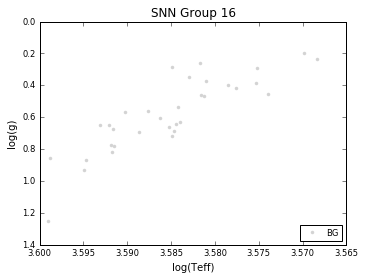

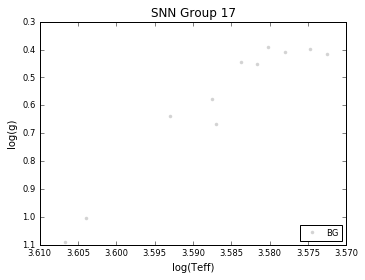

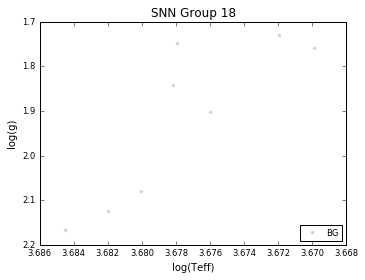

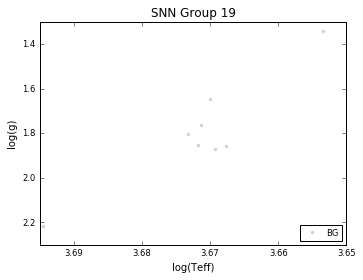

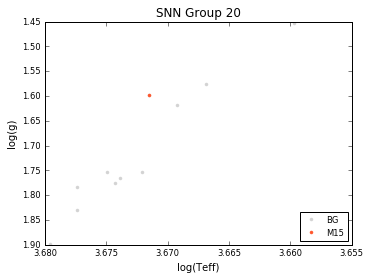

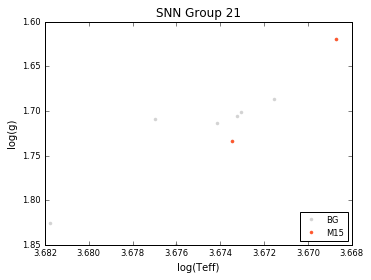

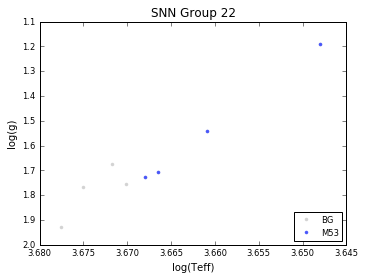

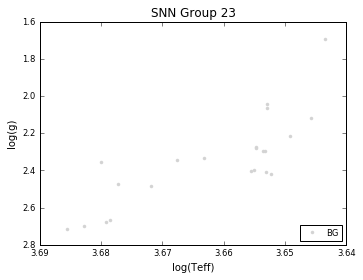

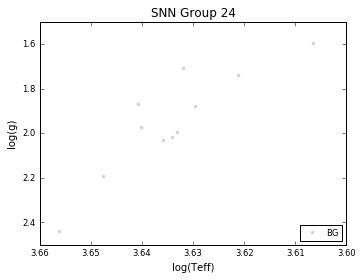

In [191]:
xlab = "log(Teff)"
ylab = "log(g)"
X = np.array([np.log10(x) for x in TEFF])
Y = LOGG
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_15["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.legend(loc=4, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
    plt.savefig("Cannon/SNN/SNN_%i_Teff_logg.png"%n, dpi=150)
    plt.show()

0


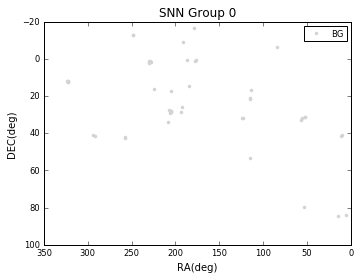

1


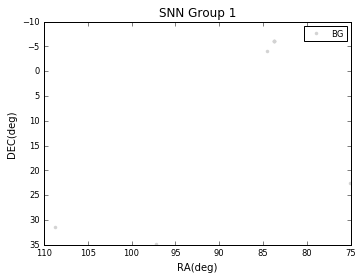

2


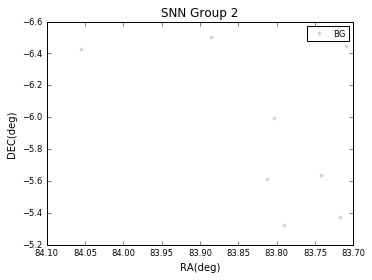

3


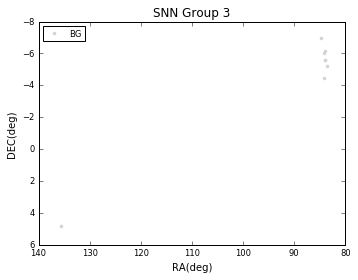

4


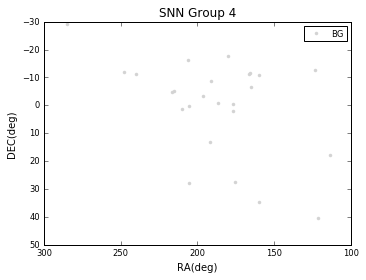

5


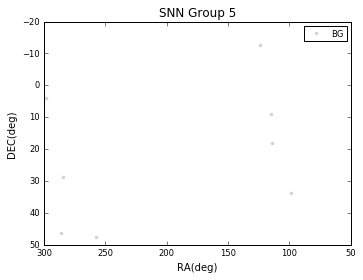

6


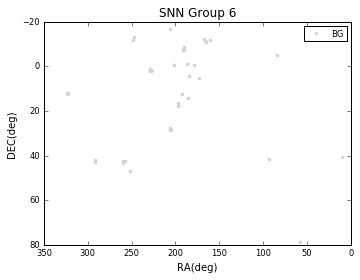

7


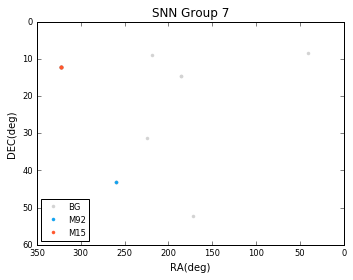

8


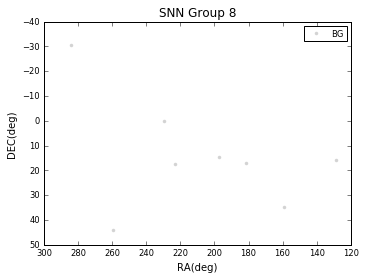

9


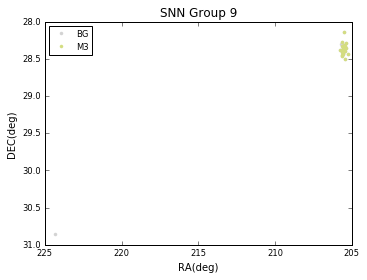

10


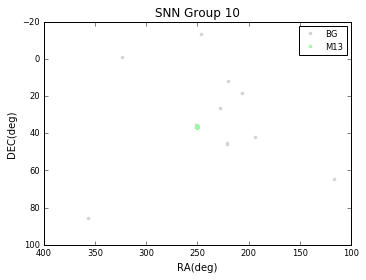

11


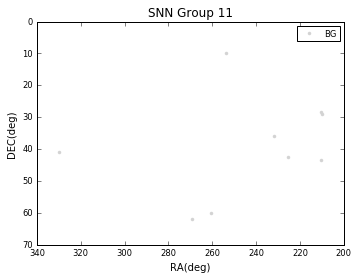

12


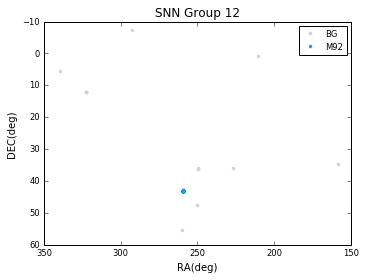

13


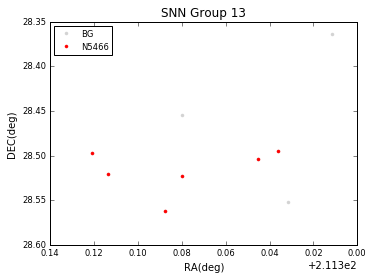

14


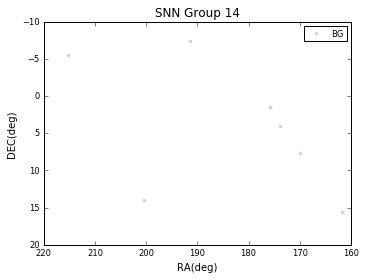

15


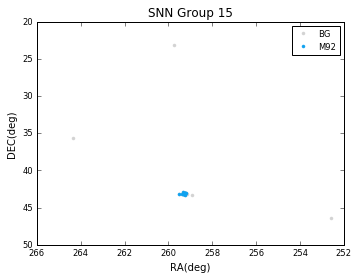

16


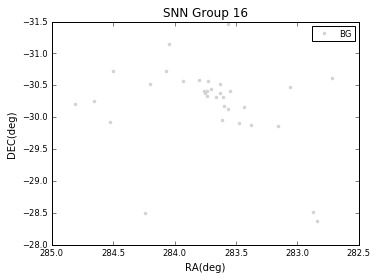

17


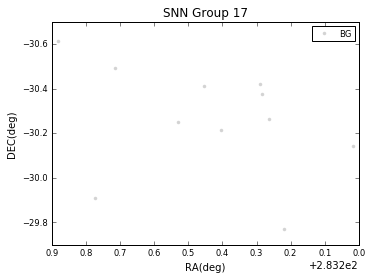

18


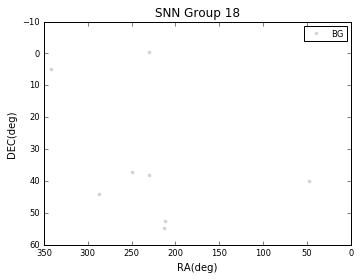

19


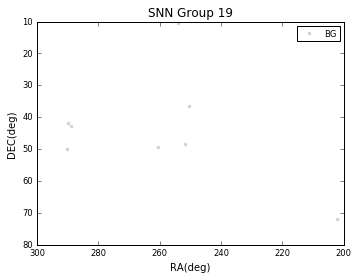

20


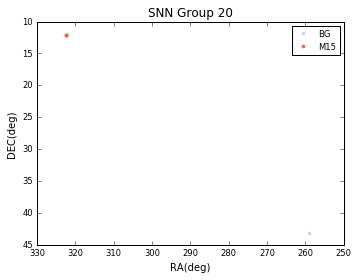

21


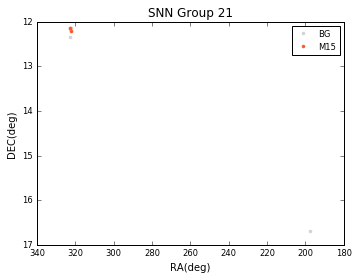

22


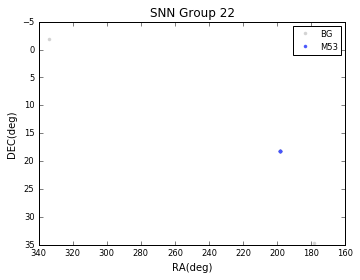

23


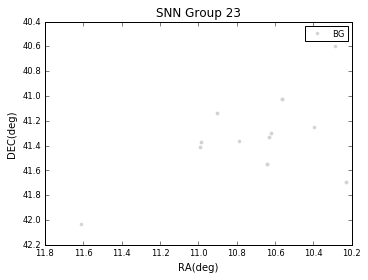

24


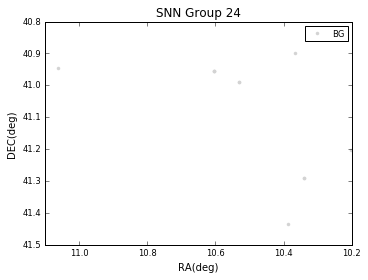

In [190]:
xlab = "RA(deg)"
ylab = "DEC(deg)"
X = RA
Y = DEC
for n in range(max(labels)+1):
    print n
    group = non_noise[np.where(labels == n)[0]]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_15["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.legend(loc=0, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
    plt.savefig("Cannon/SNN/SNN_%i_RA_DEC.png"%n, dpi=150)
    plt.show()

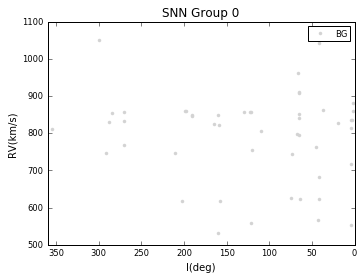

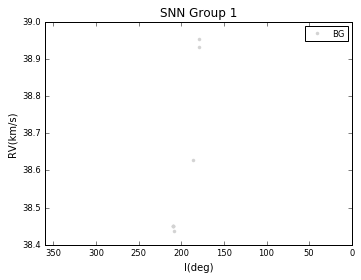

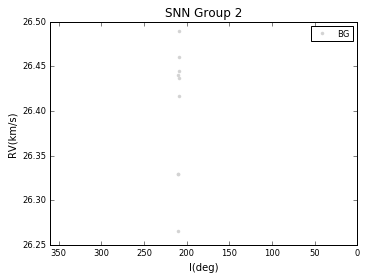

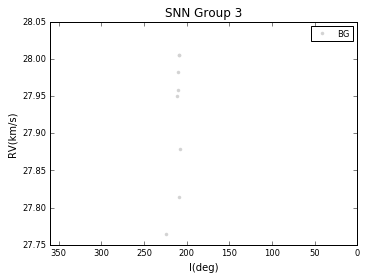

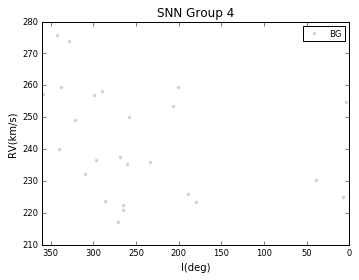

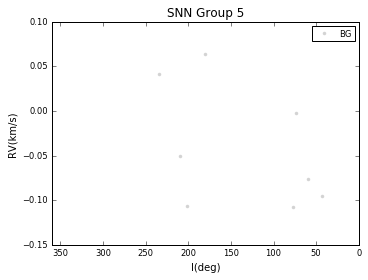

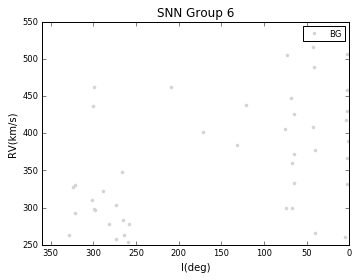

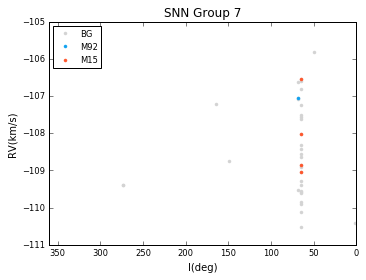

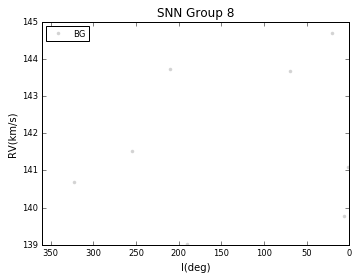

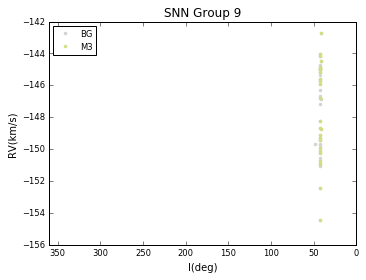

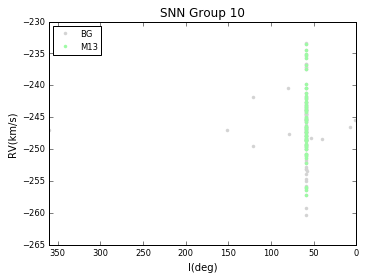

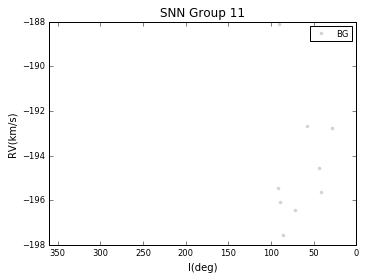

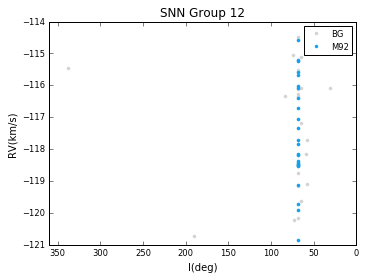

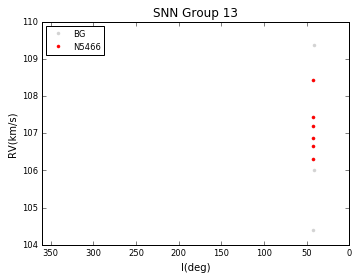

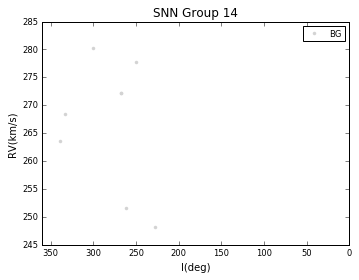

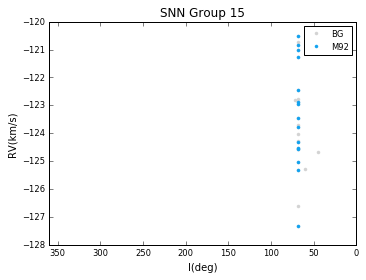

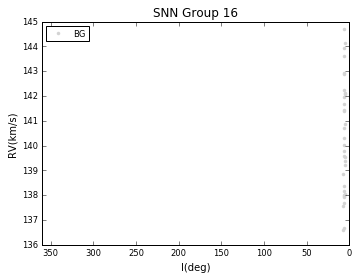

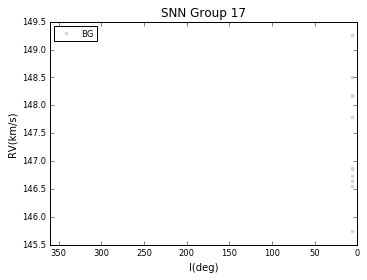

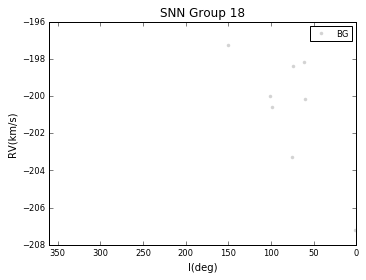

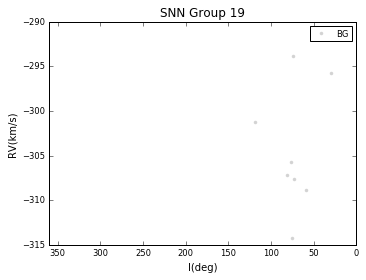

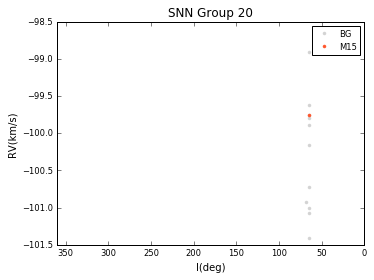

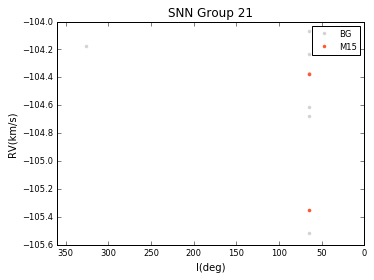

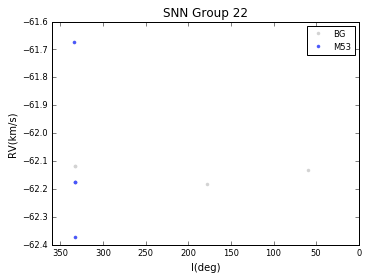

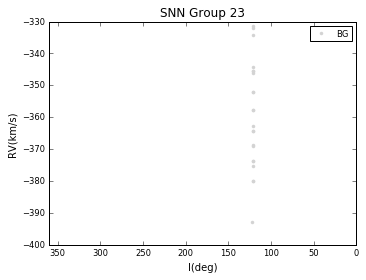

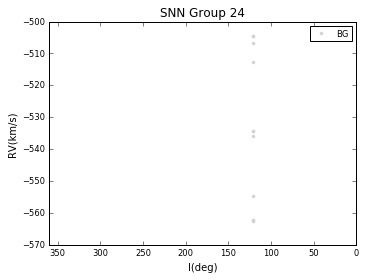

In [199]:
xlab = "l(deg)"
ylab = "RV(km/s)"
X = GLON
Y = RV
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_15["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.xlim(360, 0)
    plt.legend(loc=0, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
    plt.savefig("Cannon/SNN/SNN_%i_l_RV.png"%n, dpi=150)
    plt.show()

In [139]:
recover_names = np.array(["M92", "M5", "M13", "M3", "N5466"])
tidal_radius = np.array([14.850, 29.652, 27.195, 35.397, 52.754])
center_RA = np.array([259.28042, 229.64083, 250.42292, 205.54667, 211.3625])
center_DEC = np.array([43.13639, 2.08278, 36.46028, 28.37556, 28.5344])
names = ["cluster_name", "tidal_radius", "RA", "DEC"]
dtype = ["string", "float", "float", "float"]
tidal_table = Table([recover_names, tidal_radius, center_RA, center_DEC], names=names, dtype=dtype)

In [144]:
def rad(degree):
    return degree * np.pi / 180.

def ang_distance(RA1, RA2, DEC1, DEC2):
    cos_d = np.sin(rad(DEC1)) * np.sin(rad(DEC2)) + np.cos(rad(DEC1)) * np.cos(rad(DEC2)) * np.cos(rad(RA1 - RA2))
    d = np.arccos(cos_d) * 180. / np.pi
    return d*60

In [185]:
xlab = "[Mg/Fe]"
ylab = "[Al/Fe]"
X = MG
Y = AL
for n in plot_labels:
    group = non_noise[np.where(labels == n)[0]]
    fig = plt.figure(figsize=(5.5, 4))
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_15["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            tidal_index = np.where(tidal_table["cluster_name"] == name)[0]
            group_RA = RA[group]
            group_DEC = DEC[group]
            center_RA = tidal_table["RA"][tidal_index]
            center_DEC = tidal_table["DEC"][tidal_index]
            tidal_radius = tidal_table["tidal_radius"][tidal_index]
            angular_dist = ang_distance(group_RA, center_RA, group_DEC, center_DEC) 
            print [x for x in angular_dist / tidal_radius if x > 1]
            rad_1 = np.where(angular_dist <= tidal_radius)[0]
            rad_2 = np.where((angular_dist > tidal_radius) * (angular_dist <= 3.0*tidal_radius))[0]
            rad_3 = np.where(angular_dist > 3.0 *tidal_radius)[0]
            rad_1 = group[rad_1]
            rad_2 = group[rad_2]
            rad_3 = group[rad_3]
            plt.plot(X[group_members], Y[group_members], "o", label=name, alpha=0.6, markerfacecolor='None')
            plt.plot(X[rad_1], Y[rad_1], ".", c='orangered', label='< 1 r', alpha = 0.8)
            if len(rad_2) > 0:
                plt.plot(X[rad_2], Y[rad_2], ".", c='b', label='< 3 r')
            if len(rad_3) > 0:
                plt.plot(X[rad_3], Y[rad_3], ".", c='y', label='> 3 r')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=0, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
    plt.savefig("Cannon/SNN/SNN_%i_tidal_radius.png"%n, dpi=150)
    plt.show()

ValueError: operands could not be broadcast together with shapes (64273,) (0,) 

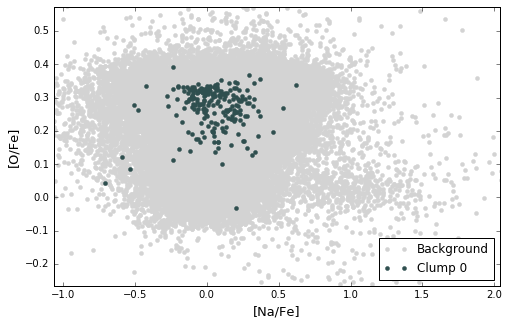

In [44]:
n = 0
ms= 8
stars = non_noise[np.where(labels == n)[0]]
fig = plt.figure(figsize=(8,5))
plt.plot(NA, O, '.', c='lightgrey', label='Background', ms=ms)
plt.plot(NA[stars], O[stars], '.', c='darkslategrey', label='Clump %i'%n, ms=ms)
plt.xlabel('[Na/Fe]', fontsize=13)
plt.ylabel('[O/Fe]', fontsize=13)
plt.xlim(np.mean(NA) - 4.0*np.std(NA), np.mean(NA) + 7.0*np.std(NA))
plt.ylim(np.mean(O) - 3.5*np.std(O), np.mean(O) + 3.5*np.std(O))
plt.legend(loc='lower right')
plt.show()

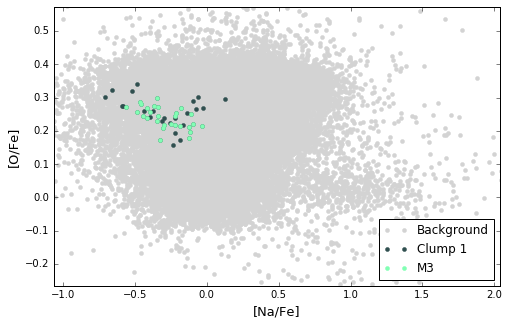

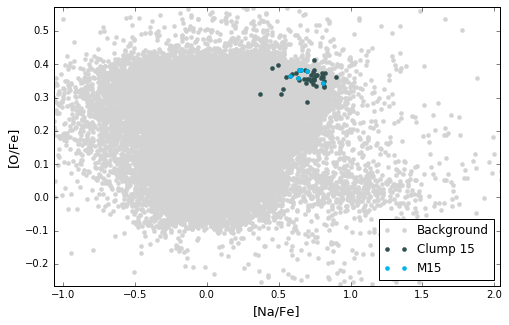

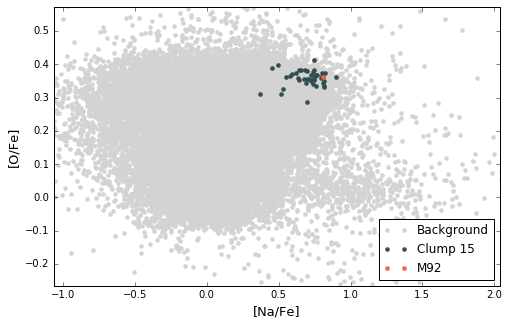

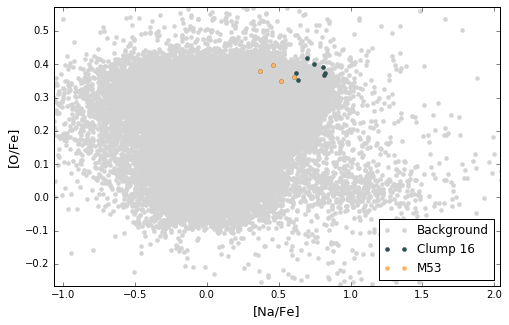

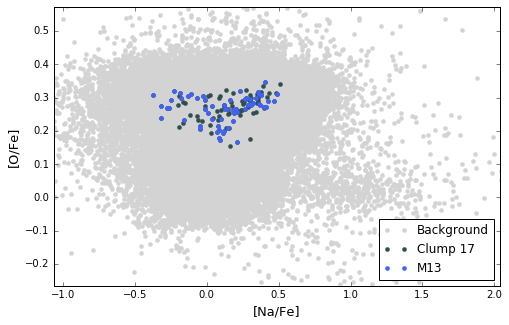

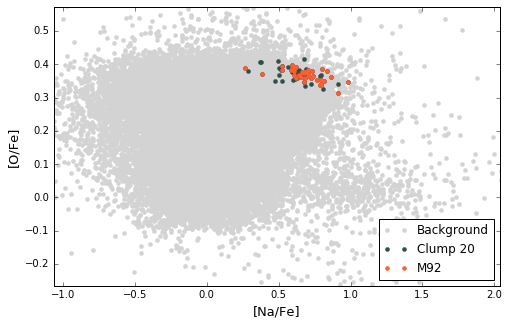

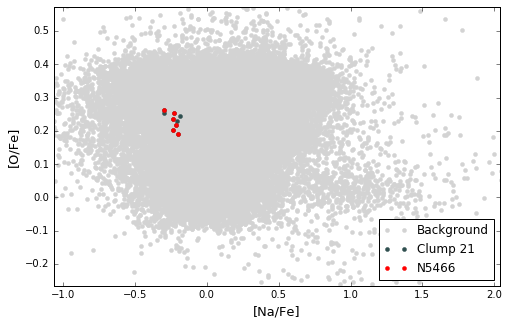

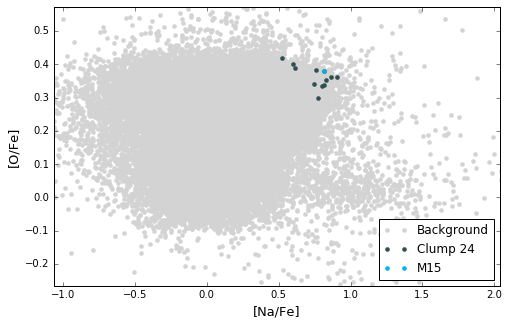

In [54]:
clump_recover = np.array([], dtype='int')
clump_labels = np.array([], dtype='int')
plot_clumps = []
for n in range(n_clumps+1):
    ms = 8
    stars = non_noise[np.where(labels == n)[0]]
    clump_recover = np.append(clump_recover, stars)
    clump_labels = np.append(clump_labels, np.array([m for k in range(len(stars))]))
    for i in range(num_g_c):
        cluster_members = np.where(ap_table_15['label'] == globular_labels[i])[0]
        recovered = np.intersect1d(cluster_members, stars)
        if len(recovered) > 0:
            plot_clumps.append(n)
            fig = plt.figure(figsize=(8,5))
            plt.plot(NA, O, '.', c='lightgrey', label='Background', ms=ms)
            plt.plot(NA[stars], O[stars], '.', c='darkslategrey', label='Clump %i'%n, ms=ms)
            cm = plt.get_cmap('rainbow')
            plt.plot(NA[recovered], O[recovered], '.', 
                     c=cm(colors[i]), label=globular_names[i], ms=ms)
            plt.xlabel('[Na/Fe]', fontsize=13)
            plt.ylabel('[O/Fe]', fontsize=13)
            plt.xlim(np.mean(NA) - 4.0*np.std(NA), np.mean(NA) + 7.0*np.std(NA))
            plt.ylim(np.mean(O) - 3.5*np.std(O), np.mean(O) + 3.5*np.std(O))
            plt.legend(loc='lower right')
            plt.show()

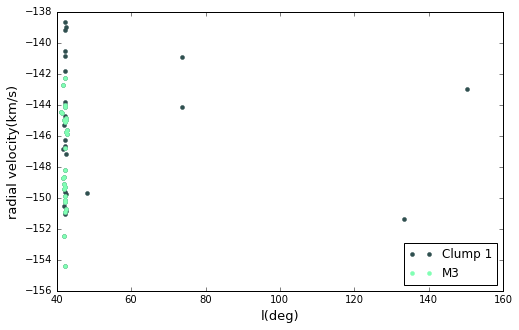

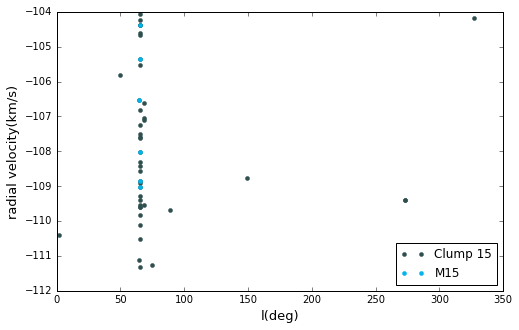

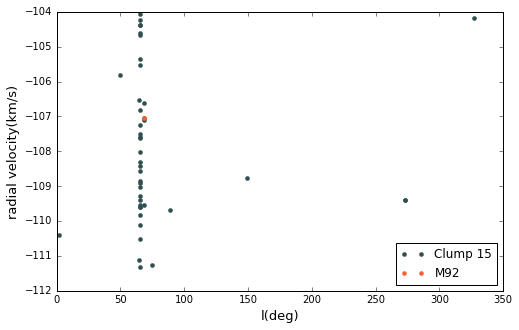

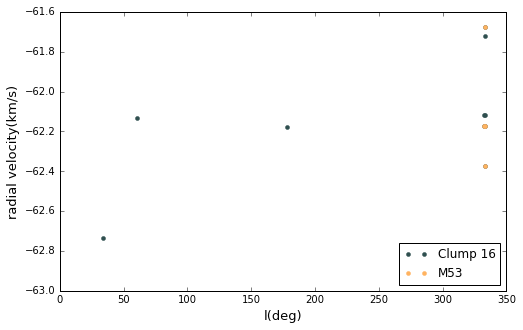

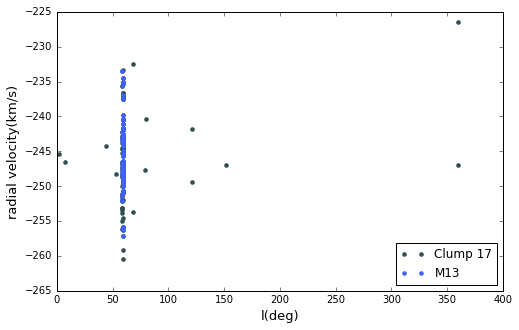

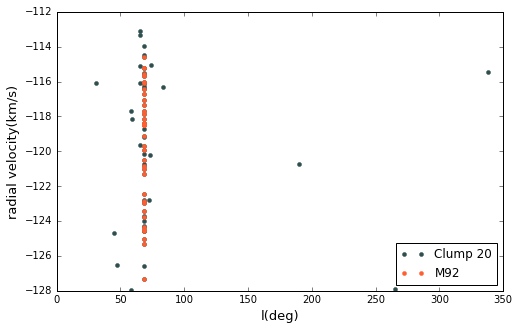

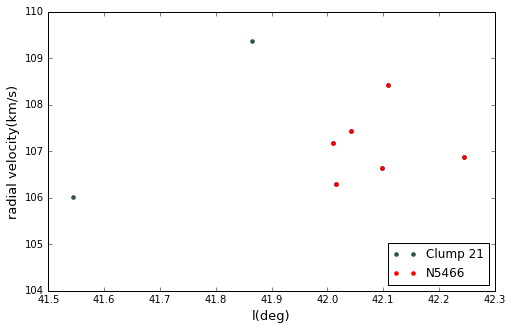

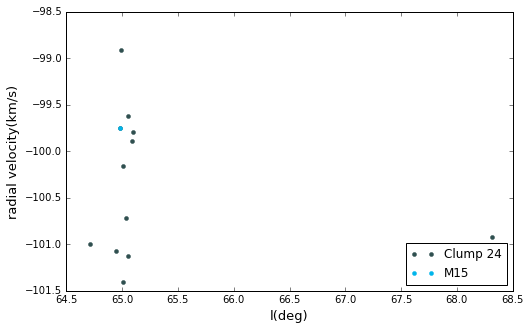

In [56]:
n_clumps = np.amax(labels)
clump_recover = np.array([], dtype='int')
clump_labels = np.array([], dtype='int')
for n in range(n_clumps+1):
    ms = 8
    stars = non_noise[np.where(labels == n)[0]]
    clump_recover = np.append(clump_recover, stars)
    clump_labels = np.append(clump_labels, np.array([n for k in range(len(stars))]))
    for i in range(num_g_c):
        cluster_members = np.where(ap_table_15['label'] == globular_labels[i])[0]
        recovered = np.intersect1d(cluster_members, stars)
        if len(recovered) > 0:
            fig = plt.figure(figsize=(8,5))
            X = GLON
            Y = RV
            x_label = 'l(deg)'
            y_label = 'radial velocity(km/s)'
#             plt.plot(X, Y, '.', c='lightgrey', label='Background', ms=ms)
            plt.plot(X[stars], Y[stars], '.', c='darkslategrey', label='Clump %i'%n, ms=ms)
            cm = plt.get_cmap('rainbow')
            plt.plot(X[recovered], Y[recovered], '.', 
                     c=cm(colors[i]), label=globular_names[i], ms=ms)
            plt.xlabel(x_label, fontsize=13)
            plt.ylabel(y_label, fontsize=13)
            plt.legend(loc='lower right')
            plt.show()

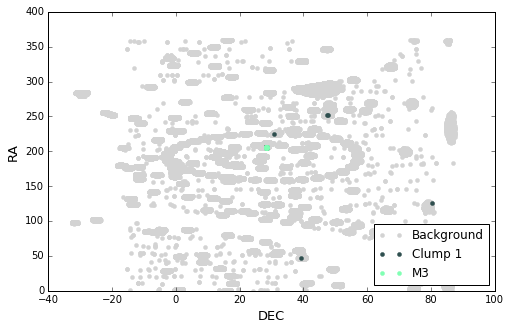

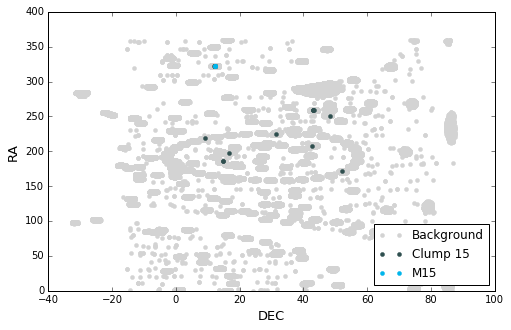

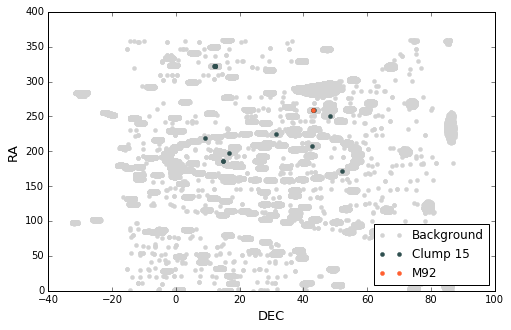

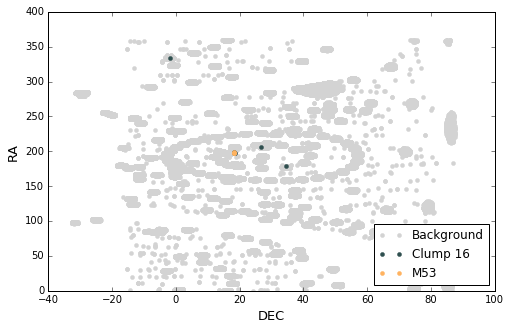

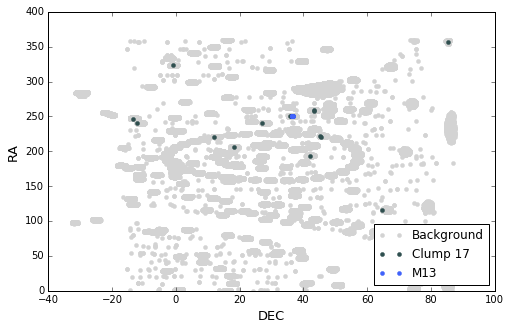

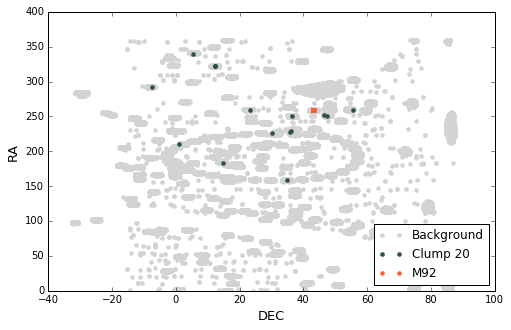

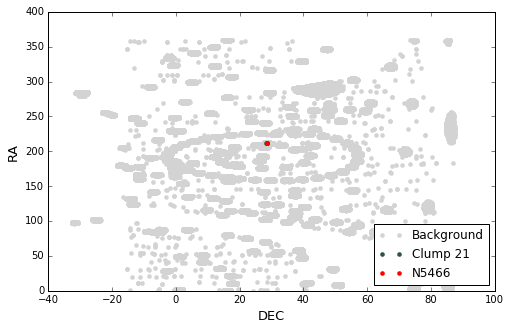

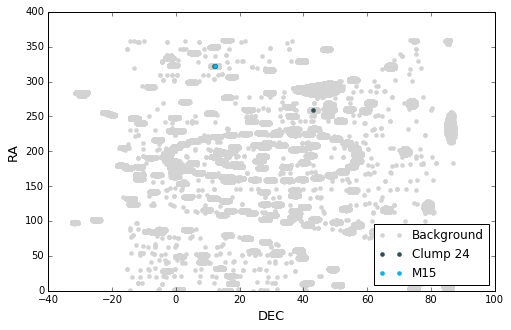

In [55]:
n_clumps = np.amax(labels)
clump_recover = np.array([], dtype='int')
clump_labels = np.array([], dtype='int')
for n in range(n_clumps+1):
    ms = 8
    stars = non_noise[np.where(labels == n)[0]]
    clump_recover = np.append(clump_recover, stars)
    clump_labels = np.append(clump_labels, np.array([n for k in range(len(stars))]))
    for i in range(num_g_c):
        cluster_members = np.where(ap_table_15['label'] == globular_labels[i])[0]
        recovered = np.intersect1d(cluster_members, stars)
        if len(recovered) > 0:
            fig = plt.figure(figsize=(8,5))
            X = DEC
            Y = RA
            x_label = 'DEC'
            y_label = 'RA'
            plt.plot(X, Y, '.', c='lightgrey', label='Background', ms=ms)
            plt.plot(X[stars], Y[stars], '.', c='darkslategrey', label='Clump %i'%n, ms=ms)
            cm = plt.get_cmap('rainbow')
            plt.plot(X[recovered], Y[recovered], '.', 
                     c=cm(colors[i]), label=globular_names[i], ms=ms)
            plt.xlabel(x_label, fontsize=13)
            plt.ylabel(y_label, fontsize=13)
            plt.legend(loc='lower right')
            plt.show()

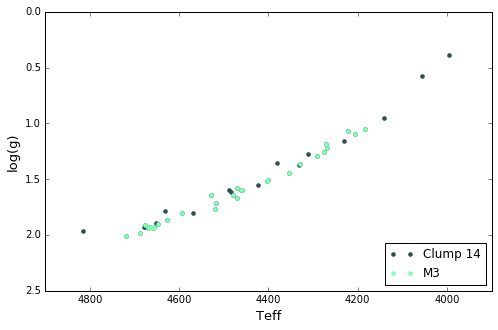

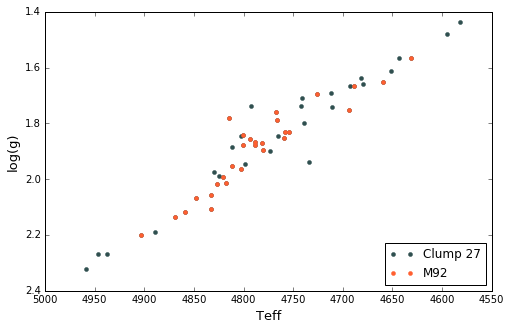

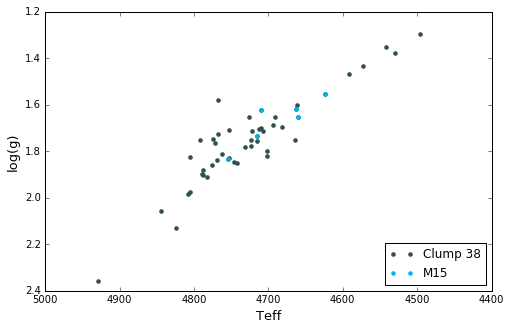

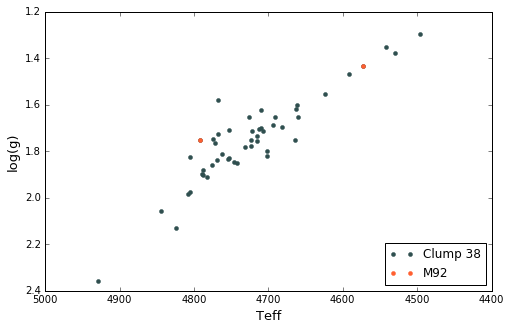

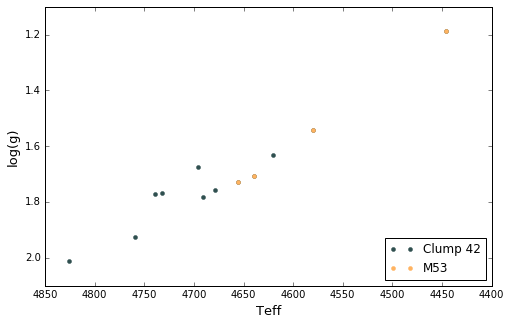

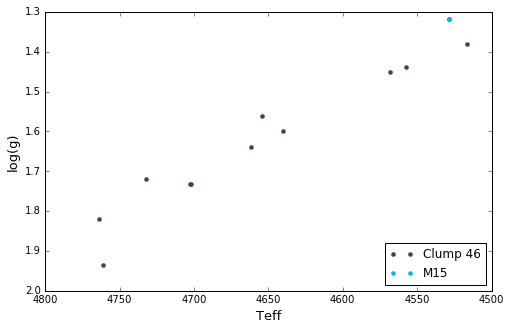

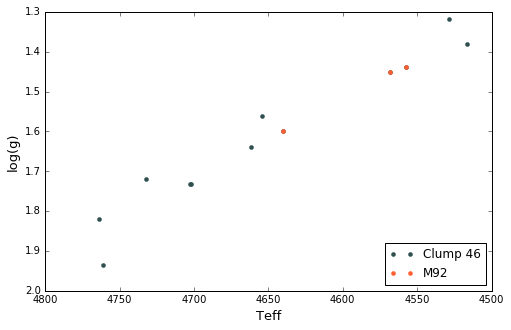

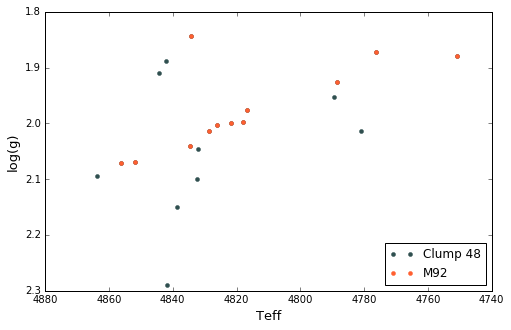

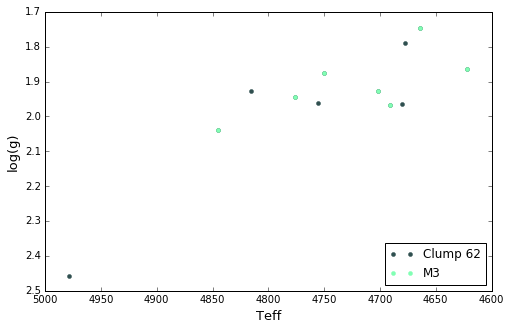

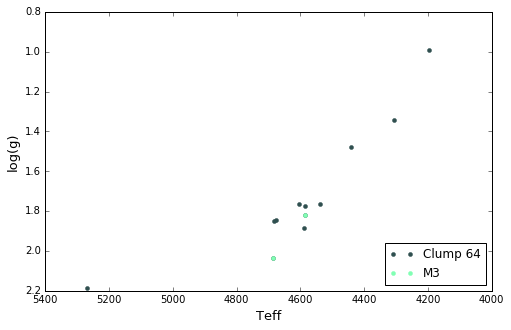

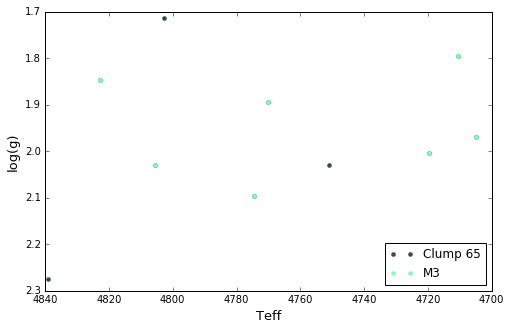

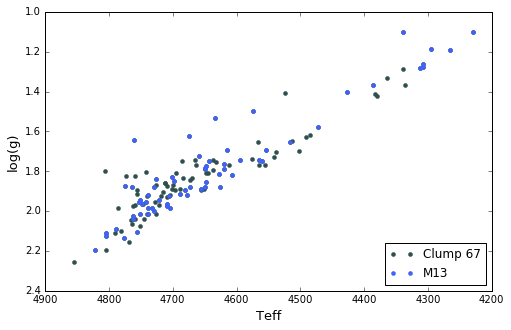

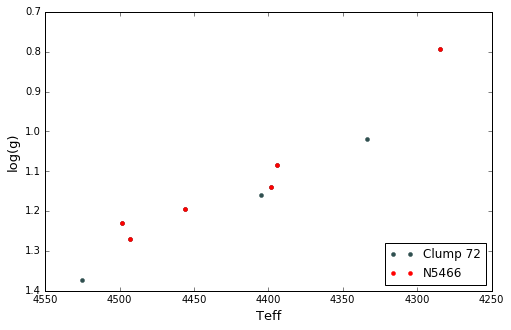

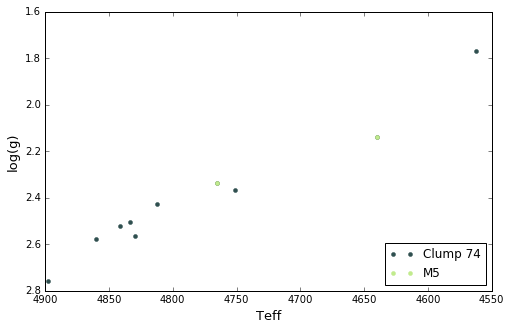

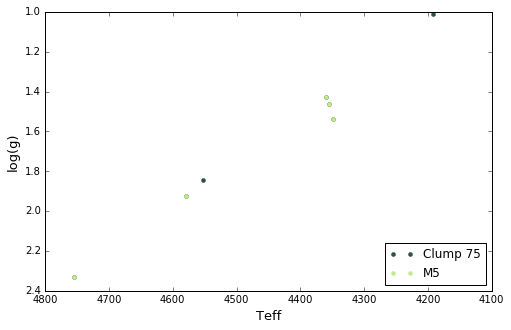

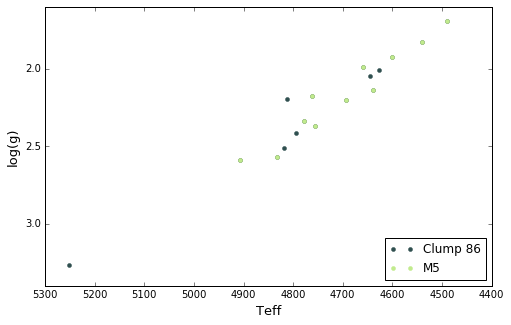

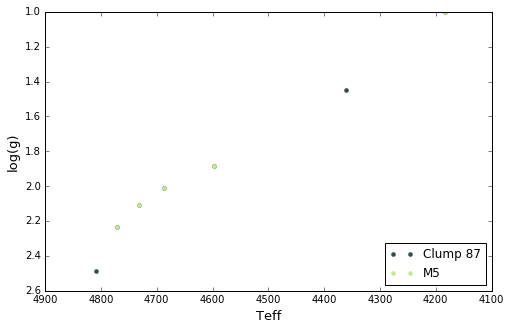

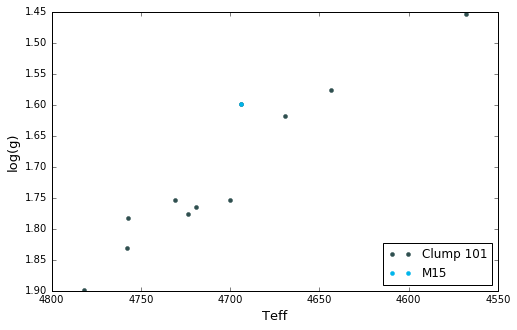

In [42]:
n_clumps = np.amax(labels)
clump_recover = np.array([], dtype='int')
clump_labels = np.array([], dtype='int')
for n in range(n_clumps+1):
    ms = 8
    stars = non_noise[np.where(labels == n)[0]]
    clump_recover = np.append(clump_recover, stars)
    clump_labels = np.append(clump_labels, np.array([n for k in range(len(stars))]))
    for i in range(num_g_c):
        cluster_members = np.where(ap_table_15['label'] == globular_labels[i])[0]
        recovered = np.intersect1d(cluster_members, stars)
        if len(recovered) > 0:
            fig = plt.figure(figsize=(8,5))
            X = TEFF
            Y = LOGG
            x_label = 'Teff'
            y_label = 'log(g)'
#             plt.plot(X, Y, '.', c='lightgrey', label='Background', ms=ms)
            plt.plot(X[stars], Y[stars], '.', c='darkslategrey', label='Clump %i'%n, ms=ms)
            cm = plt.get_cmap('rainbow')
            plt.plot(X[recovered], Y[recovered], '.', 
                     c=cm(colors[i]), label=globular_names[i], ms=ms)
            plt.xlabel(x_label, fontsize=13)
            plt.ylabel(y_label, fontsize=13)
            plt.legend(loc='lower right')
            plt.xlim(plt.xlim()[::-1])
            plt.ylim(plt.ylim()[::-1])
            plt.show()

In [25]:
# clump_table = ap_table_15[np.where(labels != -1)[0]]
# col = Column(labels[[np.where(labels != -1)[0]]], name='clump_labels')
# clump_table.add_column(col)
# clump_table.write('ISNN_halo_all_stars_results.csv', format='csv')